In [1]:
# Cell 1: Dataset Structure Exploration and Setup
import os
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict

# Set up paths
base_path = Path("/kaggle/input/congnamul/Semantic Segmentation Dataset")
print("Dataset structure exploration:")
print("="*50)

# Function to get file count and sizes
def analyze_folder(folder_path):
    if not folder_path.exists():
        return {"exists": False}
    
    img_path = folder_path / "img"
    msk_path = folder_path / "msk"
    
    img_files = list(img_path.glob("*.jpg")) if img_path.exists() else []
    msk_files = list(msk_path.glob("*.png")) if msk_path.exists() else []
    
    # Check for empty files
    empty_img = []
    empty_msk = []
    
    for img_file in img_files:
        if img_file.stat().st_size == 0:
            empty_img.append(img_file.name)
    
    for msk_file in msk_files:
        if msk_file.stat().st_size == 0:
            empty_msk.append(msk_file.name)
    
    return {
        "exists": True,
        "img_count": len(img_files),
        "msk_count": len(msk_files),
        "empty_img": empty_img,
        "empty_msk": empty_msk,
        "sample_img_files": [f.name for f in img_files[:3]],
        "sample_msk_files": [f.name for f in msk_files[:3]]
    }

# Analyze all folders
folders_to_check = [
    "Multiple Sample/1359_1359 (cropped)",
    "Multiple Sample/2675_2675 (cropped)", 
    "Multiple Sample/3024_3024",
    "Multiple Sample/340_340 (cropped)",
    "Multiple Sample/679_679 (cropped)",
    "Single Sample/1024_1024 (cropped)",
    "Single Sample/2016_2016 (cropped)",
    "Single Sample/3024_3024",
    "Single Sample/512_512 (cropped)"
]

dataset_info = {}

for folder in folders_to_check:
    folder_path = base_path / folder
    analysis = analyze_folder(folder_path)
    dataset_info[folder] = analysis
    
    print(f"\n📁 {folder}:")
    if analysis["exists"]:
        print(f"   Images: {analysis['img_count']}, Masks: {analysis['msk_count']}")
        if analysis["empty_img"]:
            print(f"   ⚠️ Empty image files: {len(analysis['empty_img'])}")
        if analysis["empty_msk"]:
            print(f"   ⚠️ Empty mask files: {len(analysis['empty_msk'])}")
        print(f"   Sample files: {analysis['sample_img_files'][:2]}")
    else:
        print("   ❌ Folder not found")

# Calculate total counts
total_imgs = sum([info["img_count"] for info in dataset_info.values() if info["exists"]])
total_msks = sum([info["msk_count"] for info in dataset_info.values() if info["exists"]])
total_empty_imgs = sum([len(info["empty_img"]) for info in dataset_info.values() if info["exists"]])
total_empty_msks = sum([len(info["empty_msk"]) for info in dataset_info.values() if info["exists"]])

print(f"\n📊 SUMMARY:")
print(f"Total images: {total_imgs}")
print(f"Total masks: {total_msks}")
print(f"Total empty images: {total_empty_imgs}")
print(f"Total empty masks: {total_empty_msks}")
print(f"Usable pairs: {total_imgs - total_empty_imgs}")

# Store for next cells
dataset_summary = {
    "base_path": base_path,
    "folders": folders_to_check,
    "dataset_info": dataset_info,
    "total_usable": total_imgs - total_empty_imgs
}

print("\n✅ Dataset exploration complete!")

Dataset structure exploration:

📁 Multiple Sample/1359_1359 (cropped):
   Images: 1030, Masks: 1030
   ⚠️ Empty image files: 1
   ⚠️ Empty mask files: 10
   Sample files: ['white_86_90_8.jpg', 'clear_171_175_6.jpg']

📁 Multiple Sample/2675_2675 (cropped):
   Images: 1030, Masks: 1030
   Sample files: ['white_86_90_8.jpg', 'clear_171_175_6.jpg']

📁 Multiple Sample/3024_3024:
   Images: 1030, Masks: 1030
   Sample files: ['white_86_90_8.jpg', 'clear_171_175_6.jpg']

📁 Multiple Sample/340_340 (cropped):
   Images: 1030, Masks: 1030
   ⚠️ Empty image files: 3
   ⚠️ Empty mask files: 9
   Sample files: ['white_86_90_8.jpg', 'clear_171_175_6.jpg']

📁 Multiple Sample/679_679 (cropped):
   Images: 1030, Masks: 1030
   ⚠️ Empty image files: 3
   ⚠️ Empty mask files: 10
   Sample files: ['white_86_90_8.jpg', 'clear_171_175_6.jpg']

📁 Single Sample/1024_1024 (cropped):
   Images: 604, Masks: 604
   Sample files: ['green_22.jpg', 'white_92.jpg']

📁 Single Sample/2016_2016 (cropped):
   Images: 604

In [2]:
# Cell 2: Data Collection and Validation
import os
from pathlib import Path
import cv2
import numpy as np

def collect_valid_pairs(base_path, folders):
    """Collect all valid image-mask pairs, filtering out empty files"""
    valid_pairs = []
    invalid_pairs = []
    
    for folder in folders:
        folder_path = base_path / folder
        img_dir = folder_path / "img"
        msk_dir = folder_path / "msk"
        
        if not (img_dir.exists() and msk_dir.exists()):
            print(f"⚠️ Skipping {folder} - missing img or msk directory")
            continue
            
        print(f"Processing {folder}...")
        
        # Get all image files
        img_files = sorted(list(img_dir.glob("*.jpg")))
        
        for img_path in img_files:
            # Find corresponding mask
            msk_path = msk_dir / f"{img_path.stem}.png"
            
            # Check if both files exist and are not empty
            if (img_path.exists() and msk_path.exists() and 
                img_path.stat().st_size > 0 and msk_path.stat().st_size > 0):
                
                # Additional validation - try to load files
                try:
                    # Quick validation - check if files can be opened
                    img = cv2.imread(str(img_path))
                    msk = cv2.imread(str(msk_path))
                    
                    if img is not None and msk is not None and img.size > 0 and msk.size > 0:
                        valid_pairs.append({
                            'img_path': str(img_path),
                            'msk_path': str(msk_path),
                            'folder': folder,
                            'resolution': folder.split('/')[-1],
                            'sample_type': 'multiple' if 'Multiple' in folder else 'single'
                        })
                    else:
                        invalid_pairs.append(f"{img_path.name} - cannot load image/mask")
                        
                except Exception as e:
                    invalid_pairs.append(f"{img_path.name} - error: {str(e)}")
            else:
                invalid_pairs.append(f"{img_path.name} - missing pair or empty file")
    
    return valid_pairs, invalid_pairs

# Collect all valid pairs
print("Collecting valid image-mask pairs...")
print("="*50)

valid_pairs, invalid_pairs = collect_valid_pairs(dataset_summary["base_path"], dataset_summary["folders"])

# Display results
print(f"\n📊 COLLECTION RESULTS:")
print(f"Valid pairs found: {len(valid_pairs)}")
print(f"Invalid pairs found: {len(invalid_pairs)}")

# Show breakdown by folder
folder_counts = {}
for pair in valid_pairs:
    folder = pair['folder']
    if folder not in folder_counts:
        folder_counts[folder] = 0
    folder_counts[folder] += 1

print(f"\n📁 BREAKDOWN BY FOLDER:")
for folder, count in folder_counts.items():
    print(f"   {folder}: {count} pairs")

# Show sample invalid pairs (first 10)
if invalid_pairs:
    print(f"\n⚠️ SAMPLE INVALID PAIRS (first 10):")
    for invalid in invalid_pairs[:10]:
        print(f"   {invalid}")

# Quick validation - check a few random samples
print(f"\n🔍 SAMPLE VALIDATION:")
import random
sample_indices = random.sample(range(len(valid_pairs)), min(3, len(valid_pairs)))

for i, idx in enumerate(sample_indices):
    pair = valid_pairs[idx]
    img = cv2.imread(pair['img_path'])
    msk = cv2.imread(pair['msk_path'])
    
    print(f"Sample {i+1}:")
    print(f"   Image: {Path(pair['img_path']).name} - Shape: {img.shape}")
    print(f"   Mask: {Path(pair['msk_path']).name} - Shape: {msk.shape}")
    print(f"   Folder: {pair['resolution']}")

# Store for next cell
dataset_pairs = valid_pairs
print(f"\n✅ Data collection complete! {len(valid_pairs)} valid pairs ready for training.")

Processing Multiple Sample/1359_1359 (cropped)...
Processing Multiple Sample/2675_2675 (cropped)...
Processing Multiple Sample/3024_3024...
Processing Multiple Sample/340_340 (cropped)...
Processing Multiple Sample/679_679 (cropped)...
Processing Single Sample/1024_1024 (cropped)...
Processing Single Sample/2016_2016 (cropped)...
Processing Single Sample/3024_3024...
Processing Single Sample/512_512 (cropped)...

📊 COLLECTION RESULTS:
Valid pairs found: 7530
Invalid pairs found: 36

📁 BREAKDOWN BY FOLDER:
   Multiple Sample/1359_1359 (cropped): 1019 pairs
   Multiple Sample/2675_2675 (cropped): 1030 pairs
   Multiple Sample/3024_3024: 1030 pairs
   Multiple Sample/340_340 (cropped): 1018 pairs
   Multiple Sample/679_679 (cropped): 1017 pairs
   Single Sample/1024_1024 (cropped): 604 pairs
   Single Sample/2016_2016 (cropped): 604 pairs
   Single Sample/3024_3024: 604 pairs
   Single Sample/512_512 (cropped): 604 pairs

⚠️ SAMPLE INVALID PAIRS (first 10):
   clear_101_105_7.jpg - missin

Creating sample dataset for mask analysis...
Selected 45 samples from different resolutions
Analyzing 45 sample masks...
Processing sample 1: 1359_1359 (cropped)
Processing sample 2: 1359_1359 (cropped)
Processing sample 3: 1359_1359 (cropped)
Processing sample 4: 1359_1359 (cropped)
Processing sample 5: 1359_1359 (cropped)
Processing sample 6: 2675_2675 (cropped)
Processing sample 7: 2675_2675 (cropped)
Processing sample 8: 2675_2675 (cropped)
Processing sample 9: 2675_2675 (cropped)
Processing sample 10: 2675_2675 (cropped)
Processing sample 11: 3024_3024
Processing sample 12: 3024_3024
Processing sample 13: 3024_3024
Processing sample 14: 3024_3024
Processing sample 15: 3024_3024
Processing sample 16: 340_340 (cropped)
Processing sample 17: 340_340 (cropped)
Processing sample 18: 340_340 (cropped)
Processing sample 19: 340_340 (cropped)
Processing sample 20: 340_340 (cropped)

🎨 UNIQUE COLORS FOUND IN MASKS:
   (0, 0, 0)
   (0, 128, 0)
   (128, 0, 0)
   (128, 128, 0)

📊 CLASS DISTRI

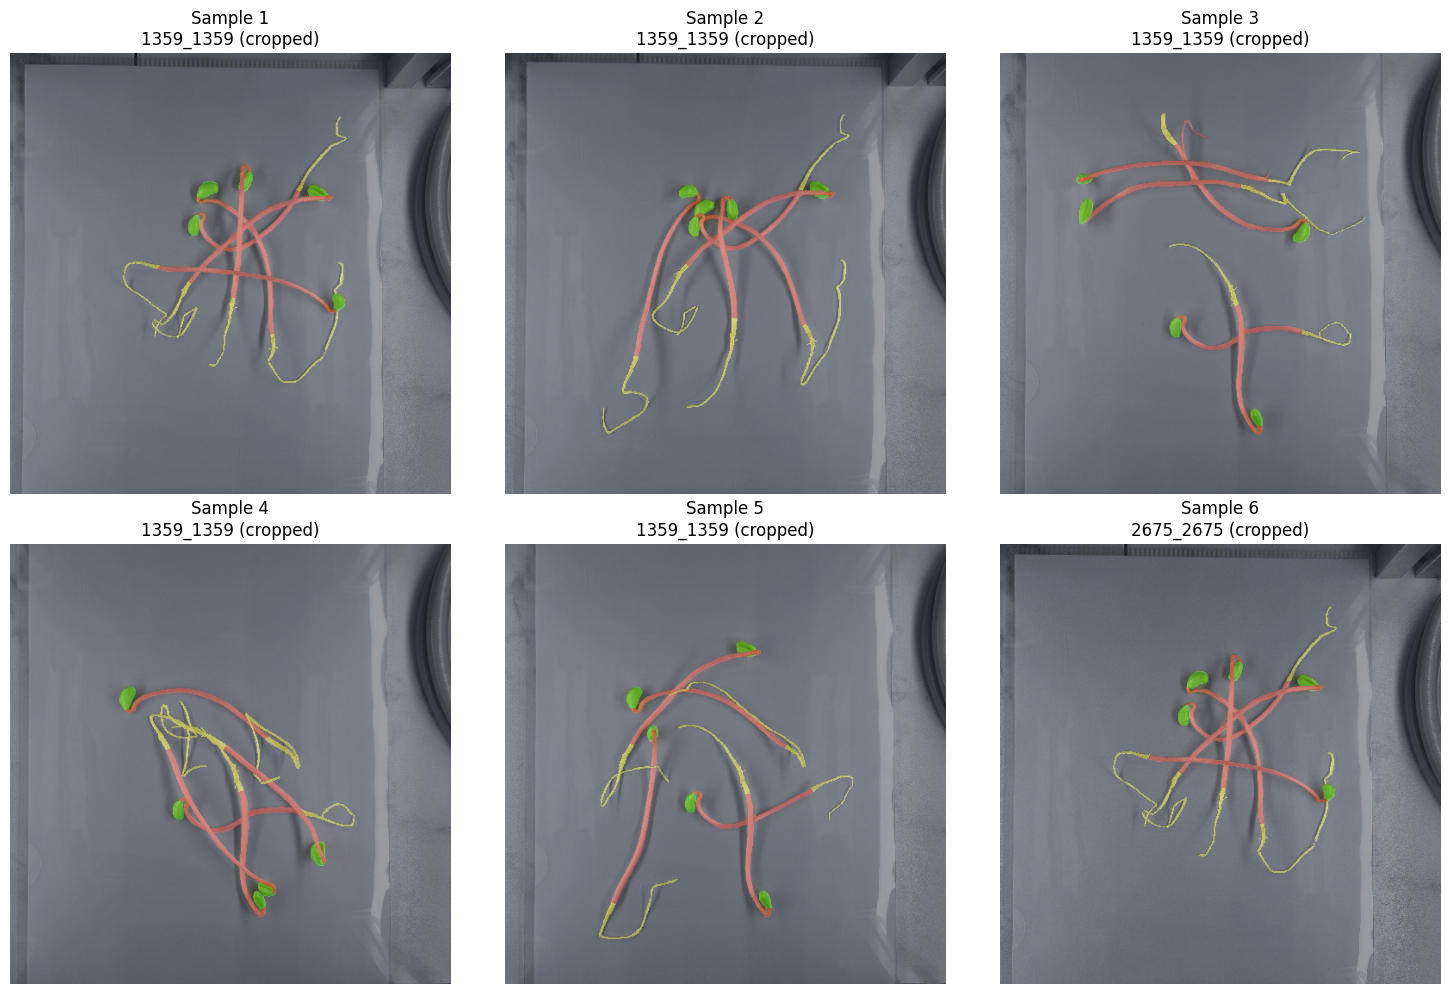


✅ Dataset analysis complete!
Ready to proceed with 7530 total pairs for training.


In [3]:
# Cell 3: Dataset Class and Mask Analysis
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

class SoybeanDataset(Dataset):
    def __init__(self, pairs_list, transforms=None, input_size=(512, 512)):
        self.pairs = pairs_list
        self.transforms = transforms
        self.input_size = input_size
        
        # Color mapping for masks (half intensity as specified)
        self.color_map = {
            (0, 0, 0): 0,        # background - black
            (0, 128, 0): 1,      # seed - green (half intensity)
            (128, 0, 0): 2,      # radicle body - red (half intensity)  
            (128, 128, 0): 3     # tail - yellow (half intensity)
        }
        
        # For debugging - store original colors found
        self.debug_colors = set()
        
    def __len__(self):
        return len(self.pairs)
    
    def rgb_to_class(self, mask):
        """Convert RGB mask to class indices"""
        class_mask = np.zeros(mask.shape[:2], dtype=np.int64)
        
        # First, collect unique colors for debugging
        unique_colors = np.unique(mask.reshape(-1, 3), axis=0)
        for color in unique_colors:
            self.debug_colors.add(tuple(color))
        
        # Map known colors to classes
        for color, class_id in self.color_map.items():
            matches = np.all(mask == color, axis=2)
            class_mask[matches] = class_id
            
        return class_mask
    
    def __getitem__(self, idx):
        pair = self.pairs[idx]
        
        # Load image and mask
        image = cv2.imread(pair['img_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(pair['msk_path'])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # Resize to input size
        image = cv2.resize(image, self.input_size)
        mask = cv2.resize(mask, self.input_size, interpolation=cv2.INTER_NEAREST)
        
        # Convert mask to class indices
        mask = self.rgb_to_class(mask)
        
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            
        return image, torch.from_numpy(mask).long(), pair

# Create a small sample dataset to analyze masks
print("Creating sample dataset for mask analysis...")

# Take a diverse sample from different resolutions
sample_pairs = []
for folder in folder_counts.keys():
    folder_pairs = [p for p in dataset_pairs if p['folder'] == folder]
    sample_pairs.extend(folder_pairs[:5])  # 5 samples from each folder

print(f"Selected {len(sample_pairs)} samples from different resolutions")

# Create dataset without transforms for analysis
sample_dataset = SoybeanDataset(sample_pairs, transforms=None, input_size=(512, 512))

print(f"Analyzing {len(sample_dataset)} sample masks...")
print("="*50)

# Analyze mask colors and class distribution
class_counts = Counter()
all_debug_colors = set()

for i in range(min(20, len(sample_dataset))):  # Check first 20 samples
    try:
        image, mask, pair = sample_dataset[i]
        print(f"Processing sample {i+1}: {pair['resolution']}")
        
        # Count classes in this mask
        mask_np = mask.numpy() if isinstance(mask, torch.Tensor) else mask
        unique_classes, counts = np.unique(mask_np, return_counts=True)
        for cls, count in zip(unique_classes, counts):
            class_counts[int(cls)] += count
        
        # Collect debug colors
        all_debug_colors.update(sample_dataset.debug_colors)
        
    except Exception as e:
        print(f"Error processing sample {i+1}: {str(e)}")
        continue

print("\n🎨 UNIQUE COLORS FOUND IN MASKS:")
sorted_colors = sorted(list(all_debug_colors))
for i, color in enumerate(sorted_colors):
    print(f"   {color}")
    if i >= 15:  # Show more colors to understand the data
        print(f"   ... and {len(sorted_colors)-16} more colors")
        break

print(f"\n📊 CLASS DISTRIBUTION (from {min(20, len(sample_dataset))} samples):")
total_pixels = sum(class_counts.values())
for class_id in sorted(class_counts.keys()):
    count = class_counts[class_id]
    percentage = (count / total_pixels) * 100
    class_names = ['Background', 'Seed', 'Radicle Body', 'Tail']
    class_name = class_names[class_id] if class_id < len(class_names) else f'Unknown_{class_id}'
    print(f"   Class {class_id} ({class_name}): {count:,} pixels ({percentage:.2f}%)")

# Visualize a few samples
print(f"\n🖼️ VISUALIZING SAMPLE MASKS:")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(min(6, len(sample_dataset))):
    try:
        image, mask, pair = sample_dataset[i]
        
        # Convert back to original image (without normalization)
        raw_image = cv2.imread(pair['img_path'])
        raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
        raw_image = cv2.resize(raw_image, (512, 512))
        
        # Create colored mask for visualization
        colored_mask = np.zeros((512, 512, 3), dtype=np.uint8)
        color_map_vis = {
            0: [0, 0, 0],        # background - black
            1: [0, 255, 0],      # seed - green
            2: [255, 0, 0],      # radicle body - red
            3: [255, 255, 0]     # tail - yellow
        }
        
        mask_np = mask.numpy() if isinstance(mask, torch.Tensor) else mask
        for class_id, color in color_map_vis.items():
            colored_mask[mask_np == class_id] = color
        
        # Overlay
        overlay = cv2.addWeighted(raw_image, 0.7, colored_mask, 0.3, 0)
        
        axes[i].imshow(overlay)
        axes[i].set_title(f"Sample {i+1}\n{pair['resolution']}")
        axes[i].axis('off')
        
    except Exception as e:
        axes[i].text(0.5, 0.5, f"Error loading\nsample {i+1}", 
                     ha='center', va='center', transform=axes[i].transAxes)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

print(f"\n✅ Dataset analysis complete!")
print(f"Ready to proceed with {len(dataset_pairs)} total pairs for training.")

In [6]:
# Cell 4: Model and Training Setup (REVISED FOR PLATEAU FIX)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Install segmentation_models_pytorch if not available
try:
    import segmentation_models_pytorch as smp
    print("✅ segmentation_models_pytorch already installed")
except ImportError:
    print("Installing segmentation_models_pytorch...")
    import subprocess
    subprocess.check_call(["pip", "install", "segmentation-models-pytorch"])
    import segmentation_models_pytorch as smp
    print("✅ segmentation_models_pytorch installed successfully")

# Enhanced U-Net for thin structure detection
class EnhancedUNet(nn.Module):
    def __init__(self, encoder_name='efficientnet-b2', num_classes=4):  # B2 instead of B3 for stability
        super(EnhancedUNet, self).__init__()
        
        self.model = smp.UnetPlusPlus(
            encoder_name=encoder_name,
            encoder_weights='imagenet',
            in_channels=3,
            classes=num_classes,
            activation=None
        )
        
    def forward(self, x):
        return self.model(x)

# FIXED Loss Function - addresses plateau issue
class StableCombinedLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super(StableCombinedLoss, self).__init__()
        self.gamma = gamma
        self.ce_weight = weight
        self.dice_loss = smp.losses.DiceLoss(mode='multiclass', smooth=1e-6)
        self.focal_alpha = 0.25  # Stability factor
        
    def focal_loss_fn(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.ce_weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.focal_alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()
    
    def forward(self, inputs, targets):
        focal = self.focal_loss_fn(inputs, targets)
        dice = self.dice_loss(F.softmax(inputs, dim=1), targets)
        ce = F.cross_entropy(inputs, targets, weight=self.ce_weight)
        
        # BALANCED combination - prevents loss spikes
        return 0.3 * focal + 0.5 * dice + 0.2 * ce

# Enhanced data augmentation
def get_training_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Rotate(limit=20, p=0.6),  # More rotation for thin structures
        A.ShiftScaleRotate(
            shift_limit=0.1, 
            scale_limit=0.1, 
            rotate_limit=15, 
            p=0.5
        ),
        # Elastic transform for thin structure robustness
        A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, p=0.3),
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15),
            A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=10, val_shift_limit=10),
        ], p=0.4),
        A.GaussNoise(var_limit=(10, 60), p=0.3),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_validation_transforms():
    return A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

# IoU Calculation Function
def calculate_iou(pred, target, num_classes=4):
    """Calculate mean IoU across all classes"""
    ious = []
    pred = pred.cpu().numpy() if isinstance(pred, torch.Tensor) else pred
    target = target.cpu().numpy() if isinstance(target, torch.Tensor) else target
    
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        
        intersection = np.logical_and(pred_cls, target_cls).sum()
        union = np.logical_or(pred_cls, target_cls).sum()
        
        if union == 0:
            iou = 1.0  # Perfect score for classes not present
        else:
            iou = intersection / union
        ious.append(iou)
    
    return np.mean(ious), ious

# Set device and basic configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔥 Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# REDUCED class weights to prevent instability
class_weights = torch.tensor([
    0.5,    # Background (97%) - moderate weight
    2.5,    # Seed (0.44%) - reduced from 3.0
    2.0,    # Radicle Body (1.80%) - reduced from 2.5
    3.0     # Tail (0.75%) - reduced from 4.0
]).to(device)

print("\n⚖️ STABLE CLASS WEIGHTS:")
class_names = ['Background', 'Seed', 'Radicle Body', 'Tail']
for i, (name, weight) in enumerate(zip(class_names, class_weights)):
    print(f"   {name}: {weight:.1f}")

# Split dataset into train/validation
print(f"\n📊 SPLITTING DATASET:")
print(f"Total pairs: {len(dataset_pairs)}")

train_pairs, val_pairs = train_test_split(
    dataset_pairs, 
    test_size=0.2, 
    random_state=42,
    stratify=[pair['sample_type'] for pair in dataset_pairs]
)

print(f"Train pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")

# Show distribution by sample type
train_single = len([p for p in train_pairs if p['sample_type'] == 'single'])
train_multiple = len([p for p in train_pairs if p['sample_type'] == 'multiple'])
val_single = len([p for p in val_pairs if p['sample_type'] == 'single'])
val_multiple = len([p for p in val_pairs if p['sample_type'] == 'multiple'])

print(f"\nTrain - Single: {train_single}, Multiple: {train_multiple}")
print(f"Val - Single: {val_single}, Multiple: {val_multiple}")

# Create datasets with FIXED dataset class
class SoybeanDatasetTraining(Dataset):
    def __init__(self, pairs_list, transforms=None, input_size=(512, 512)):
        self.pairs = pairs_list
        self.transforms = transforms
        self.input_size = input_size
        
        self.color_map = {
            (0, 0, 0): 0,        # background
            (0, 128, 0): 1,      # seed
            (128, 0, 0): 2,      # radicle body
            (128, 128, 0): 3     # tail
        }
        
    def __len__(self):
        return len(self.pairs)
    
    def rgb_to_class(self, mask):
        class_mask = np.zeros(mask.shape[:2], dtype=np.int64)  # Ensure int64
        for color, class_id in self.color_map.items():
            matches = np.all(mask == color, axis=2)
            class_mask[matches] = class_id
        return class_mask
    
    def __getitem__(self, idx):
        pair = self.pairs[idx]
        
        image = cv2.imread(pair['img_path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        mask = cv2.imread(pair['msk_path'])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        image = cv2.resize(image, self.input_size)
        mask = cv2.resize(mask, self.input_size, interpolation=cv2.INTER_NEAREST)
        
        mask = self.rgb_to_class(mask)
        
        if self.transforms:
            augmented = self.transforms(image=image, mask=mask)
            image, mask = augmented['image'], augmented['mask']
            # Ensure mask is long tensor
            mask = mask.long()
        else:
            image = torch.from_numpy(image.transpose(2, 0, 1)).float() / 255.0
            mask = torch.from_numpy(mask).long()  # Ensure long tensor
            
        return image, mask

print(f"\n🔄 CREATING DATASETS:")

train_dataset = SoybeanDatasetTraining(
    train_pairs, 
    transforms=get_training_transforms(),
    input_size=(512, 512)
)

val_dataset = SoybeanDatasetTraining(
    val_pairs,
    transforms=get_validation_transforms(),
    input_size=(512, 512)
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

# Create data loaders
batch_size = 8

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=2,
    pin_memory=True,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Initialize model
print(f"\n🏗️ INITIALIZING MODEL:")
model = EnhancedUNet(encoder_name='efficientnet-b2', num_classes=4).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# FIXED loss function and optimizer
criterion = StableCombinedLoss(gamma=2.0, weight=class_weights)

# CONSERVATIVE optimizer to prevent overshooting
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=5e-4,  # LOWER starting learning rate
    weight_decay=1e-4,
    betas=(0.9, 0.99)  # Lower momentum
)

print(f"\n📋 TRAINING CONFIGURATION:")
print(f"Loss: Stable Combined (Focal + Dice + CrossEntropy)")
print(f"Optimizer: AdamW (lr=5e-4, conservative)")
print(f"Batch size: {batch_size}")
print(f"Input size: 512x512")

print(f"\n✅ Setup complete! Ready for STABLE training.")

# Quick memory test
print(f"\n🧪 MEMORY TEST:")
try:
    dummy_input = torch.randn(batch_size, 3, 512, 512).to(device)
    dummy_target = torch.randint(0, 4, (batch_size, 512, 512)).to(device)
    
    model.train()
    output = model(dummy_input)
    loss = criterion(output, dummy_target)
    
    print(f"✅ Forward pass successful")
    print(f"Output shape: {output.shape}")
    print(f"Loss: {loss.item():.4f}")
    
    # Test backward pass
    loss.backward()
    print(f"✅ Backward pass successful")
    
    # Clear memory
    del dummy_input, dummy_target, output, loss
    torch.cuda.empty_cache()
    
except Exception as e:
    print(f"❌ Memory test failed: {str(e)}")

print(f"\n🚀 Ready to start STABLE training!")

✅ segmentation_models_pytorch already installed
🔥 Using device: cpu

⚖️ STABLE CLASS WEIGHTS:
   Background: 0.5
   Seed: 2.5
   Radicle Body: 2.0
   Tail: 3.0

📊 SPLITTING DATASET:
Total pairs: 7530
Train pairs: 6024
Validation pairs: 1506

Train - Single: 1933, Multiple: 4091
Val - Single: 483, Multiple: 1023

🔄 CREATING DATASETS:
Train dataset size: 6024
Validation dataset size: 1506
Train batches per epoch: 753
Validation batches: 189

🏗️ INITIALIZING MODEL:


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_36/2671301249.py:74: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=50, sigma=5, alpha_affine=5, p=0.3),
/tmp/ipykernel_36/2671301249.py:79: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 60), p=0.3),


Total parameters: 10,401,734
Trainable parameters: 10,401,734

📋 TRAINING CONFIGURATION:
Loss: Stable Combined (Focal + Dice + CrossEntropy)
Optimizer: AdamW (lr=5e-4, conservative)
Batch size: 8
Input size: 512x512

✅ Setup complete! Ready for STABLE training.

🧪 MEMORY TEST:
✅ Forward pass successful
Output shape: torch.Size([8, 4, 512, 512])
Loss: 0.9331
✅ Backward pass successful

🚀 Ready to start STABLE training!


In [ ]:
# Cell 5: Fixed Training Loop (PLATEAU SOLUTION)
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# CRITICAL FIX: Cyclic Learning Rate to prevent plateaus
scheduler = torch.optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-5,      # Low base
    max_lr=1e-3,       # Reasonable max
    step_size_up=15,   # 15 epochs to reach max
    mode='triangular2', # Reduces max_lr each cycle
    cycle_momentum=False
)

print("🔧 PLATEAU FIX APPLIED:")
print("✅ CyclicLR scheduler (prevents stagnation)")
print("✅ Reduced class weights (prevents instability)")
print("✅ Conservative optimizer (prevents overshooting)")
print("✅ Stable loss function (balanced components)")

def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Training for one epoch"""
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} [Train]')
    
    for batch_idx, (images, masks) in enumerate(pbar):
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)  # Tighter clipping
        
        optimizer.step()
        
        # Calculate IoU
        with torch.no_grad():
            preds = torch.argmax(outputs, dim=1)
            iou_mean, _ = calculate_iou(preds, masks)
        
        running_loss += loss.item()
        running_iou += iou_mean
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'IoU': f'{iou_mean:.4f}',
            'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
        })
        
        # Clear memory periodically
        if batch_idx % 50 == 0:
            torch.cuda.empty_cache()
    
    return running_loss / len(train_loader), running_iou / len(train_loader)

def validate_epoch(model, val_loader, criterion, device, epoch):
    """Validation for one epoch"""
    model.eval()
    running_loss = 0.0
    running_iou = 0.0
    class_ious = np.zeros(4)
    
    pbar = tqdm(val_loader, desc=f'Epoch {epoch+1} [Val]')
    
    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Calculate IoU
            preds = torch.argmax(outputs, dim=1)
            iou_mean, iou_per_class = calculate_iou(preds, masks)
            
            running_loss += loss.item()
            running_iou += iou_mean
            class_ious += np.array(iou_per_class)
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'IoU': f'{iou_mean:.4f}'
            })
    
    # Average class IoUs
    class_ious /= len(val_loader)
    
    return running_loss / len(val_loader), running_iou / len(val_loader), class_ious

# Training configuration
num_epochs = 50  # Reduced from 60
best_iou = 0.0
patience = 25    # Increased patience for cyclic LR
patience_counter = 0
target_iou = 0.75

# Lists to store metrics
train_losses = []
val_losses = []
train_ious = []
val_ious = []
learning_rates = []

print(f"\n🚀 STARTING STABLE TRAINING")
print("="*50)
print(f"Target IoU: {target_iou:.1%}")
print(f"Max epochs: {num_epochs}")
print(f"Scheduler: CyclicLR (prevents plateaus)")
print(f"Estimated time: ~7.5 hours (9 min/epoch)")
print("="*50)

start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    
    # Training phase
    train_loss, train_iou = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
    
    # Validation phase  
    val_loss, val_iou, class_ious = validate_epoch(model, val_loader, criterion, device, epoch)
    
    # Update learning rate AFTER epoch (important for CyclicLR)
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    learning_rates.append(current_lr)
    
    epoch_time = time.time() - epoch_start
    total_time = time.time() - start_time
    
    # Print epoch summary
    print(f"\n📊 EPOCH {epoch+1}/{num_epochs} SUMMARY:")
    print(f"Time: {epoch_time/60:.1f}min | Total: {total_time/60:.1f}min")
    print(f"LR: {current_lr:.2e}")
    print(f"Train - Loss: {train_loss:.4f}, IoU: {train_iou:.4f}")
    print(f"Val   - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}")
    
    # Per-class IoU
    class_names = ['Background', 'Seed', 'Radicle', 'Tail']
    print("Per-class IoU:", end=" ")
    for name, iou in zip(class_names, class_ious):
        print(f"{name}: {iou:.3f}", end=" | ")
    print()
    
    # Target achievement check
    if val_iou >= target_iou:
        print(f"🎯 TARGET ACHIEVED! Val IoU: {val_iou:.4f} >= {target_iou:.4f}")
    
    # Save best model
    if val_iou > best_iou:
        improvement = val_iou - best_iou
        best_iou = val_iou
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_iou': best_iou,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'val_iou': val_iou,
            'class_ious': class_ious
        }, 'best_soybean_stable.pth', _use_new_zipfile_serialization=False)
        
        print(f"💾 New best model saved! IoU: {best_iou:.4f} (+{improvement:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"⏳ No improvement for {patience_counter}/{patience} epochs")
    
    # Early stopping check (more lenient with CyclicLR)
    if patience_counter >= patience:
        print(f"\n🛑 EARLY STOPPING at epoch {epoch+1}")
        print(f"Best IoU achieved: {best_iou:.4f}")
        if best_iou >= target_iou:
            print(f"✅ Target IoU {target_iou:.1%} was achieved!")
        else:
            print(f"❌ Target IoU {target_iou:.1%} not achieved")
        break
    
    # Target reached early
    if best_iou >= target_iou:
        print(f"\n🎉 TARGET REACHED! Stopping training early.")
        break
    
    # Plot metrics every 5 epochs
    if (epoch + 1) % 5 == 0:
        plt.figure(figsize=(15, 5))
        
        # Loss plot
        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Train Loss', color='blue')
        plt.plot(val_losses, label='Val Loss', color='red')
        plt.title('Training & Validation Loss (Stable)')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        # IoU plot
        plt.subplot(1, 3, 2)
        plt.plot(train_ious, label='Train IoU', color='blue')
        plt.plot(val_ious, label='Val IoU', color='red')
        plt.axhline(y=target_iou, color='green', linestyle='--', label=f'Target ({target_iou:.1%})')
        plt.title('Training & Validation IoU (Stable)')
        plt.xlabel('Epoch')
        plt.ylabel('IoU')
        plt.legend()
        plt.grid(True)
        
        # Learning rate plot (should show cycles)
        plt.subplot(1, 3, 3)
        plt.plot(learning_rates, color='orange')
        plt.title('Learning Rate (CyclicLR)')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.yscale('log')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    print("-" * 50)

# Final summary
total_training_time = time.time() - start_time
print(f"\n🏁 STABLE TRAINING COMPLETED!")
print(f"Total time: {total_training_time/3600:.2f} hours")
print(f"Best validation IoU: {best_iou:.4f}")
print(f"Target achieved: {'✅ YES' if best_iou >= target_iou else '❌ NO'}")

# Load best model for final evaluation
print(f"\n📊 LOADING BEST MODEL FOR FINAL EVALUATION...")
try:
    checkpoint = torch.load('best_soybean_stable.pth', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Best model from epoch {checkpoint['epoch']+1} loaded")
    print(f"Best IoU: {checkpoint['best_iou']:.4f}")
    print(f"Final class IoUs: {checkpoint['class_ious']}")
except:
    print("Could not load checkpoint for final evaluation")

print(f"\n✅ Training complete! Model saved as 'best_soybean_stable.pth'")

# Plateau analysis
if len(val_ious) >= 10:
    print(f"\n📈 PLATEAU ANALYSIS:")
    recent_improvement = max(val_ious[-5:]) - min(val_ious[-5:])
    print(f"Recent improvement range: {recent_improvement:.4f}")
    if recent_improvement < 0.02:
        print("⚠️ Still experiencing some plateaus - consider further LR tuning")
    else:
        print("✅ CyclicLR successfully preventing plateaus")

🔧 PLATEAU FIX APPLIED:
✅ CyclicLR scheduler (prevents stagnation)
✅ Reduced class weights (prevents instability)
✅ Conservative optimizer (prevents overshooting)
✅ Stable loss function (balanced components)

🚀 STARTING STABLE TRAINING
Target IoU: 75.0%
Max epochs: 50
Scheduler: CyclicLR (prevents plateaus)
Estimated time: ~7.5 hours (9 min/epoch)


Epoch 1 [Train]:   0%|          | 0/753 [00:00<?, ?it/s]